# Import File

In [1]:
import os
import glob
import shutil
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import GroupShuffleSplit
import torchvision.transforms as T
import cv2


# DATASET PATH VERIFICATION

In [2]:
# ============================================================
# STEP 1: DATASET PATH VERIFICATION
# ============================================================
data_dir = '/kaggle/input/arsenic/Original_Data'
print("Dataset path:", data_dir)
print("Exists:", os.path.exists(data_dir))
print("Subfolders:", os.listdir(data_dir))

# Optional: Copy to local path for faster I/O
local_dir = '/content/Original_Data'
if not os.path.exists(local_dir):
    shutil.copytree(data_dir, local_dir)
    print("Dataset copied locally to:", local_dir)
else:
    print("Local dataset already exists at:", local_dir)

BASE_PATH = local_dir

filepaths = []
labels = []
groups = []


for label in os.listdir(BASE_PATH):
    label_path = os.path.join(BASE_PATH, label)
    if os.path.isdir(label_path):
        for fname in os.listdir(label_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(label_path, fname))
                labels.append(label)
                groups.append(label)


df = pd.DataFrame({
    "filepath": filepaths,
    "label": labels,
    "group": groups
})

print("Total samples:", len(df))
print(df.head())

Dataset path: /kaggle/input/arsenic/Original_Data
Exists: True
Subfolders: ['infacted', 'not_infacted']
Dataset copied locally to: /content/Original_Data
Total samples: 1287
                                            filepath         label  \
0  /content/Original_Data/not_infacted/IMG2023061...  not_infacted   
1  /content/Original_Data/not_infacted/IMG2023080...  not_infacted   
2  /content/Original_Data/not_infacted/IMG2023080...  not_infacted   
3  /content/Original_Data/not_infacted/IMG2023061...  not_infacted   
4  /content/Original_Data/not_infacted/IMG2023080...  not_infacted   

          group  
0  not_infacted  
1  not_infacted  
2  not_infacted  
3  not_infacted  
4  not_infacted  


In [3]:
pip install git+https://github.com/facebookresearch/fvcore.git

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-o53r6uve
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-o53r6uve
  Resolved https://github.com/facebookresearch/fvcore.git to commit 70e69fb3ff7a82631f6a82061a7650c4f11da876
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65635 sha256=79fdc629788352374e4a9d351bc06a7c998be13191239de63e676e9e4cf1f657
  Stored in directory: /tmp/pip-ephem-wheel-cache-t22f_xr5/wheels/cb/7b/f1/170e6ac46b414a6afef30f04f353ef29c6d7b20051358b781a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=6823ff55137b996163ae9d0256b2a387efe45fd5005803ecd53ec2f6b4cd86f8
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d946

# CLASS DETECTION FROM FOLDER NAMES

In [4]:
available_classes = [f for f in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, f))]
print("Available class folders:", available_classes)

if not available_classes:
    raise ValueError("No class folders found. Check dataset path.")

CLASSES = available_classes

Available class folders: ['not_infacted', 'infacted']


# COMPUTE IMAGE STATISTICS

In [5]:
def compute_image_stats(image):
    if image.mode != "RGB":
        image = image.convert("RGB")

    arr = np.asarray(image, dtype=np.float32) / 255.0
    hsv = np.asarray(image.convert("HSV"), dtype=np.float32) / 255.0

    stats = {}
    for i, c in enumerate(['R', 'G', 'B']):
        stats[f'{c}_mean'] = arr[:, :, i].mean()
        stats[f'{c}_std'] = arr[:, :, i].std()
    for i, c in enumerate(['H', 'S', 'V']):
        stats[f'{c}_mean'] = hsv[:, :, i].mean()
        stats[f'{c}_std'] = hsv[:, :, i].std()

    stats['brightness'] = hsv[:, :, 2].mean()
    stats['contrast'] = arr.std(axis=(0,1)).mean()

    s = hsv[:, :, 1]
    stats['sat_clip_low'] = np.mean(s < 0.05)
    stats['sat_clip_high'] = np.mean(s > 0.95)

    stats['width'], stats['height'] = image.size
    stats['aspect_ratio'] = image.width / image.height

    return stats

rows = []
MAX_IMAGES = None  # Set to a number for testing (e.g., 200)

for cls in CLASSES:
    folder = os.path.join(BASE_PATH, cls)
    img_paths = glob.glob(os.path.join(folder, "*.*"))
    if MAX_IMAGES:
        img_paths = img_paths[:MAX_IMAGES]

    if not img_paths:
        print(f"No images found in folder: {folder}")
        continue

    print(f"Processing {len(img_paths)} images in class '{cls}'...")
    for path in tqdm(img_paths, desc=f"{cls} images"):
        if not path.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            continue
        try:
            img = Image.open(path)
            stats = compute_image_stats(img)
            stats["class"] = cls
            stats["filename"] = os.path.basename(path)
            rows.append(stats)
        except:
            continue

if not rows:
    raise ValueError("No valid images found. Check dataset path or folder structure.")

df_stats = pd.DataFrame(rows)
print("Total images processed:", len(df_stats))
display(df_stats.head())

Processing 546 images in class 'not_infacted'...


not_infacted images:   0%|          | 0/546 [00:00<?, ?it/s]

Processing 741 images in class 'infacted'...


infacted images:   0%|          | 0/741 [00:00<?, ?it/s]

Total images processed: 1287


,R_mean,R_std,G_mean,G_std,B_mean,B_std,H_mean,H_std,S_mean,S_std,...,V_std,brightness,contrast,sat_clip_low,sat_clip_high,width,height,aspect_ratio,class,filename
0,0.695316,0.088976,0.572566,0.088561,0.451598,0.090655,0.080867,0.005082,0.354899,0.062826,...,0.088976,0.695316,0.093286,1.371910e-06,4.913934e-05,3468,4624,0.75,not_infacted,IMG20230610181733.jpg
1,0.577354,0.080682,0.503701,0.082955,0.405659,0.083312,0.093330,0.004695,0.302068,0.050794,...,0.080682,0.577354,0.086205,0.000000e+00,0.000000e+00,3468,4624,0.75,not_infacted,IMG20230807183520.jpg
2,0.633974,0.059775,0.607313,0.069123,0.567375,0.078073,0.105668,0.033857,0.106743,0.056050,...,0.059873,0.634150,0.076029,1.479995e-01,0.000000e+00,3468,4624,0.75,not_infacted,IMG20230807183123.jpg
3,0.707919,0.082438,0.577458,0.084216,0.462828,0.086566,0.075615,0.006143,0.350953,0.071282,...,0.082438,0.707919,0.086152,3.117978e-05,9.131935e-04,3468,4624,0.75,not_infacted,IMG20230610181308.jpg
4,0.573293,0.057554,0.544498,0.059090,0.499595,0.060271,0.099822,0.009901,0.128594,0.023085,...,0.057554,0.573294,0.060929,1.870787e-07,6.235957e-08,3468,4624,0.75,not_infacted,IMG20230807183248.jpg


# HISTOGRAM VISUALIZATION 

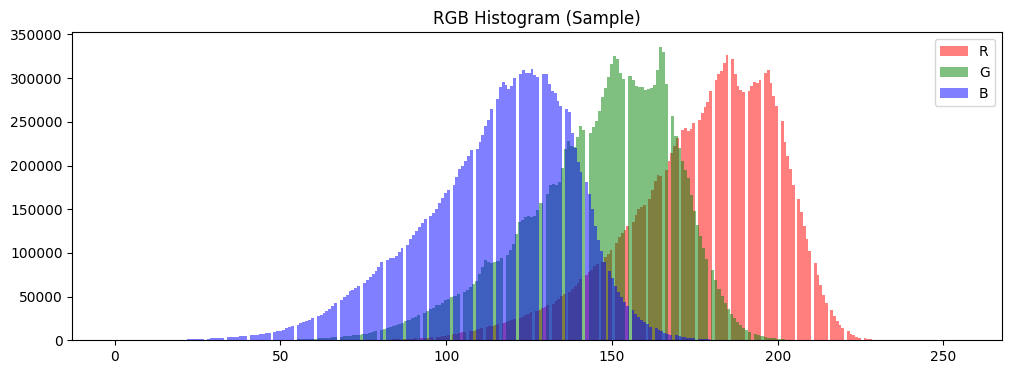

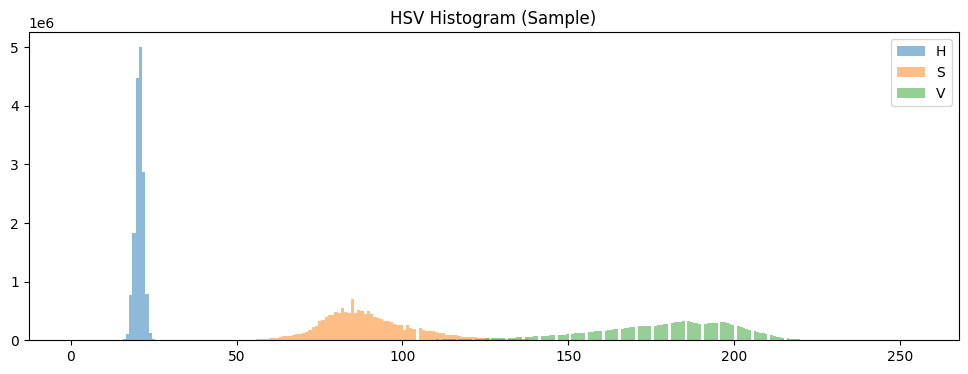

In [6]:
sample_row = df_stats.iloc[0]
sample_img_path = os.path.join(BASE_PATH, sample_row["class"], sample_row["filename"])
sample_img = Image.open(sample_img_path)
arr = np.asarray(sample_img)

plt.figure(figsize=(12,4))
for i,color in enumerate(['r','g','b']):
    plt.hist(arr[:,:,i].ravel(), bins=256, color=color, alpha=0.5, label=color.upper())
plt.title("RGB Histogram (Sample)")
plt.legend()
plt.show()

hsv = np.asarray(sample_img.convert("HSV"))
plt.figure(figsize=(12,4))
for i,color in enumerate(['h','s','v']):
    plt.hist(hsv[:,:,i].ravel(), bins=256, alpha=0.5, label=color.upper())
plt.title("HSV Histogram (Sample)")
plt.legend()
plt.show()

# PER-CLASS SUMMARY STATISTICS

Per-Class Mean & STD:


R_mean               R_std              G_mean            \
                  mean       std      mean       std      mean       std   
class                                                                      
infacted      0.684950  0.081812  0.140340  0.037378  0.545283  0.061217   
not_infacted  0.659803  0.077076  0.100049  0.039741  0.569448  0.080927   

                 G_std              B_mean            ... sat_clip_low  \
                  mean       std      mean       std  ...         mean   
class                                                 ...                
infacted      0.139184  0.035920  0.456526  0.059377  ...     0.008509   
not_infacted  0.106481  0.042616  0.496035  0.083903  ...     0.029440   

                       sat_clip_high                  width              \
                   std          mean       std         mean         std   
class                                                                     
infacted      0.029280      0.001327  0.005978  4032.000000     0.00000   
not_infacted  0.083165      0.001277  0.004610  3196.294872  1047.82375   

                   height              aspect_ratio            
                     mean          std         mean       std  
class                                                          
infacted      3024.000000     0.000000     1.333333  0.000000  
not_infacted  3656.826007  1244.889474     0.929098  0.386921  

[2 rows x 38 columns]

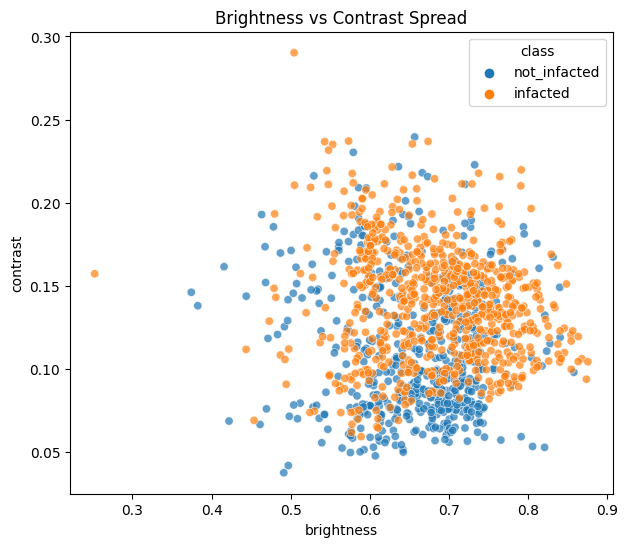

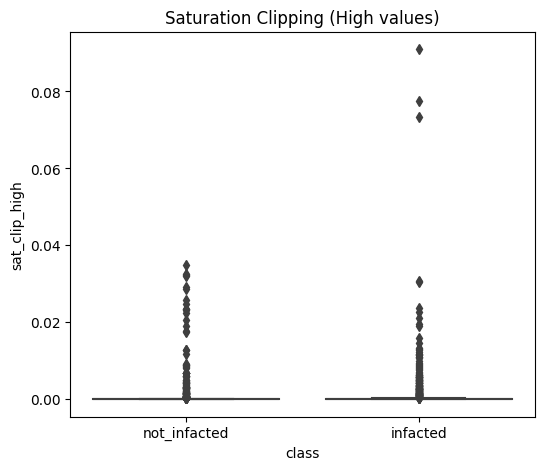

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

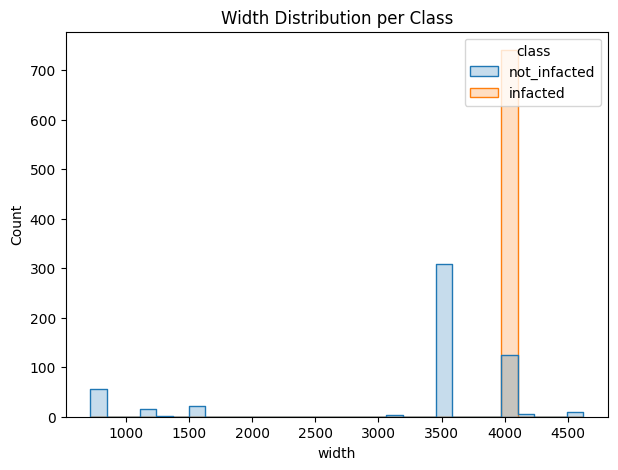

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

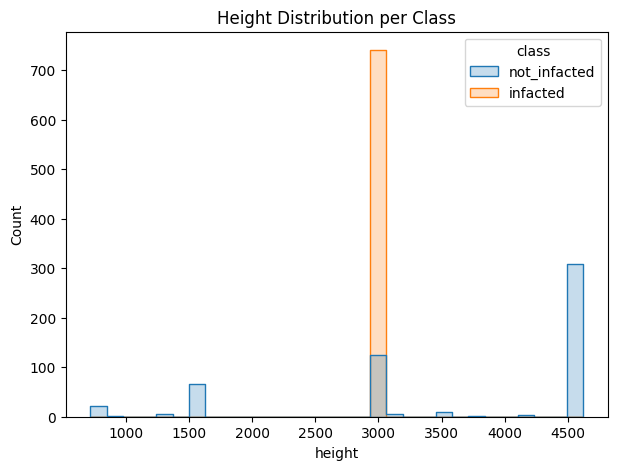

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

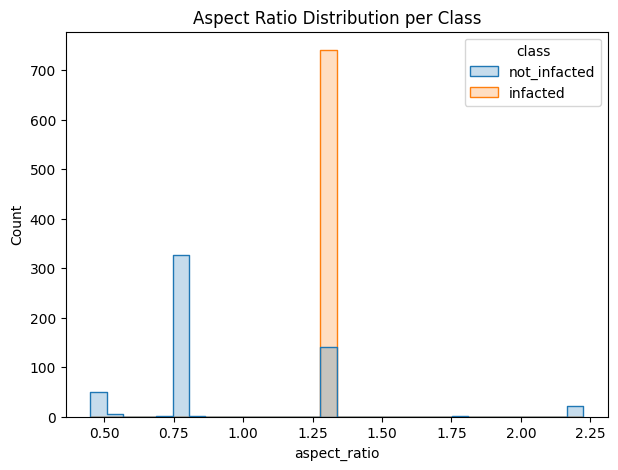

Suggested resize target: (3677x3292)

Suggested Strategy:
- Resize all images to a fixed size (e.g., 256×256)
- Maintain aspect ratio by padding (black or mean color)
- For CNNs, use random crop + resize augmentation



In [7]:
numeric_cols = df_stats.select_dtypes(include=np.number).columns.tolist()
summary = df_stats.groupby("class")[numeric_cols].agg(["mean","std"])
print("Per-Class Mean & STD:")
display(summary)

# Brightness vs Contrast
plt.figure(figsize=(7,6))
sns.scatterplot(data=df_stats, x="brightness", y="contrast", hue="class", alpha=0.7)
plt.title("Brightness vs Contrast Spread")
plt.show()

# Saturation Clipping
plt.figure(figsize=(6,5))
sns.boxplot(data=df_stats, x="class", y="sat_clip_high")
plt.title("Saturation Clipping (High values)")
plt.show()

# Resolution and Aspect Ratio
plt.figure(figsize=(7,5))
sns.histplot(data=df_stats, x="width", bins=30, hue="class", element="step")
plt.title("Width Distribution per Class")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(data=df_stats, x="height", bins=30, hue="class", element="step")
plt.title("Height Distribution per Class")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(data=df_stats, x="aspect_ratio", bins=30, hue="class", element="step")
plt.title("Aspect Ratio Distribution per Class")
plt.show()

# Suggested Resize Target
mean_w, mean_h = df_stats['width'].mean(), df_stats['height'].mean()
print(f"Suggested resize target: ({int(mean_w)}x{int(mean_h)})")
print("""
Suggested Strategy:
- Resize all images to a fixed size (e.g., 256×256)
- Maintain aspect ratio by padding (black or mean color)
- For CNNs, use random crop + resize augmentation
""")

# IMAGE QUALITY METRICS (LAPLACIAN VARIANCE & NOISE)

In [8]:
def laplacian_variance(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    lap = cv2.Laplacian(img, cv2.CV_64F)
    return lap.var()

def noise_proxy(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    noise = img.astype("float") - blurred.astype("float")
    return noise.var()

categories = CLASSES
quality_data = []

for category in categories:
    folder_path = os.path.join(BASE_PATH, category)
    for filename in tqdm(os.listdir(folder_path), desc=f"Quality check: {category}"):
        img_path = os.path.join(folder_path, filename)
        lap_var = laplacian_variance(img_path)
        noise_val = noise_proxy(img_path)
        quality_data.append({
            'filename': filename,
            'category': category,
            'laplacian_variance': lap_var,
            'noise_proxy': noise_val
        })

df_quality = pd.DataFrame(quality_data)
output_csv = '/content/laplacian_noise_results.csv'
df_quality.to_csv(output_csv, index=False)
print("CSV saved to:", output_csv)
print(df_quality.groupby('category')[['laplacian_variance', 'noise_proxy']].mean())

Quality check: not_infacted:   0%|          | 0/546 [00:00<?, ?it/s]

Quality check: infacted:   0%|          | 0/741 [00:00<?, ?it/s]

CSV saved to: /content/laplacian_noise_results.csv
              laplacian_variance  noise_proxy
category                                     
infacted               22.096996     1.227764
not_infacted           30.358032     1.568775


# DUPLICATE DETECTION (Perceptual Hashing)

In [9]:
def gray_world_correction(pil_image):
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    arr = np.asarray(pil_image).astype(np.float32)
    mean_r, mean_g, mean_b = arr[:,:,0].mean(), arr[:,:,1].mean(), arr[:,:,2].mean()
    mean_gray = (mean_r + mean_g + mean_b) / 3.0
    arr[:,:,0] = np.clip(arr[:,:,0] * (mean_gray / mean_r), 0, 255)
    arr[:,:,1] = np.clip(arr[:,:,1] * (mean_gray / mean_g), 0, 255)
    arr[:,:,2] = np.clip(arr[:,:,2] * (mean_gray / mean_b), 0, 255)
    return Image.fromarray(arr.astype(np.uint8))

def ahash(image, hash_size=8):
    image = image.convert('L').resize((hash_size, hash_size), Image.Resampling.LANCZOS)
    pixels = np.array(image)
    avg = pixels.mean()
    return ''.join(['1' if p > avg else '0' for p in pixels.flatten()])

def dhash(image, hash_size=8):
    image = image.convert('L').resize((hash_size + 1, hash_size), Image.Resampling.LANCZOS)
    pixels = np.array(image)
    diff = pixels[:, 1:] > pixels[:, :-1]
    return ''.join(['1' if v else '0' for v in diff.flatten()])

def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

image_paths = glob.glob(os.path.join(BASE_PATH, '**', '*.*'), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
print("Total image paths found:", len(image_paths))

rows = []
for img_path in tqdm(image_paths, desc="Perceptual hashing"):
    try:
        img = Image.open(img_path)
        row = {
            "filename": os.path.basename(img_path),
            "path": img_path,
            "ahash": ahash(img),
            "dhash": dhash(img)
        }
        rows.append(row)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

if not rows:
    print("No valid image data found.")
else:
    df_hash = pd.DataFrame(rows)
    df_hash = df_hash.sort_values("filename").reset_index(drop=True)
    print("Hash DataFrame:")
    display(df_hash.head())

    duplicates = []
    threshold = 5
    for (i1, row1), (i2, row2) in itertools.combinations(df_hash.iterrows(), 2):
        hd_ahash = hamming_distance(row1['ahash'], row2['ahash'])
        hd_dhash = hamming_distance(row1['dhash'], row2['dhash'])
        if hd_ahash <= threshold and hd_dhash <= threshold:
            duplicates.append({
                "file1": row1['filename'],
                "file2": row2['filename'],
                "ahash_dist": hd_ahash,
                "dhash_dist": hd_dhash
            })

    dup_df = pd.DataFrame(duplicates)
    if not dup_df.empty:
        print("Duplicates found:")
        display(dup_df)
    else:
        print("No duplicates detected.")

Total image paths found: 1287


Perceptual hashing:   0%|          | 0/1287 [00:00<?, ?it/s]

Hash DataFrame:


,filename,path,ahash,dhash
0,IMG-20230529-WA0000.jpg,/content/Original_Data/not_infacted/IMG-202305...,0000000000000000000000011000011111011111111111...,1011011111101010011011110011110100110100100101...
1,IMG-20230529-WA0001.jpg,/content/Original_Data/not_infacted/IMG-202305...,0000111100111111011011010100110100010111000101...,0111101101101111110110011101100111110100011101...
2,IMG-20230529-WA0002.jpg,/content/Original_Data/not_infacted/IMG-202305...,0000011100001111000001110000011100001111000011...,1111111011111110011111101110111011101100111011...
3,IMG-20230529-WA0003.jpg,/content/Original_Data/not_infacted/IMG-202305...,0101111111001111110011101000000010000100000001...,1001101110011010000110100010100100111101001011...
4,IMG-20230529-WA0004.jpg,/content/Original_Data/not_infacted/IMG-202305...,0000111100001111000001110000011101111111111111...,1111111000111110111111101110111111011011110000...


Duplicates found:


,file1,file2,ahash_dist,dhash_dist
0,IMG-20230529-WA0019.jpg,IMG-20230529-WA0067.jpg,2,2
1,IMG-20230529-WA0021.jpg,IMG-20230529-WA0060.jpg,4,4
2,IMG-20230529-WA0021.jpg,IMG_20230612_130410.jpg,2,5
3,IMG-20230529-WA0042.jpg,IMG-20230529-WA0046.jpg,4,3
4,IMG-20230529-WA0042.jpg,IMG20230610182635.jpg,5,4
...,...,...,...,...
77,IMG_20230612_130815.jpg,IMG_20230612_130817.jpg,4,2
78,IMG_20230616_153459.jpg,IMG_20230616_153500.jpg,3,1
79,IMG_2025.JPG,IMG_2026.JPG,1,2
80,IMG_2074.JPG,IMG_2075.JPG,1,5


# DATAFRAME BUILDING & GROUPED TRAIN-TEST SPLIT

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

train_groups = []
test_groups = []

# Split safely per label
for lbl, sub_df in df.groupby("label"):
    groups = sub_df["group"].unique()
    n_groups = len(groups)

    if n_groups < 2:
        print(f" Label '{lbl}' has only {n_groups} group(s) — assigning all to train.")
        train_groups.extend(groups)
        continue

    # otherwise, do normal 80/20 split
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
    train_idx, test_idx = next(gss.split(groups, groups=groups))
    train_groups.extend(groups[train_idx])
    test_groups.extend(groups[test_idx])

# build full DataFrames
train_df = df[df["group"].isin(train_groups)].reset_index(drop=True)
test_df = df[df["group"].isin(test_groups)].reset_index(drop=True)

# print summary
print("\n Safe Label-wise Group Split Complete")
print("---------------------------------------")
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("Unique groups in train:", train_df["group"].nunique())
print("Unique groups in test:", test_df["group"].nunique())

print("\n Train class distribution:")
print(train_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# save csvs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)
print("\n Train/Test split CSVs saved in /kaggle/working/")

 Label 'infacted' has only 1 group(s) — assigning all to train.
 Label 'not_infacted' has only 1 group(s) — assigning all to train.

 Safe Label-wise Group Split Complete
---------------------------------------
Train size: 1287
Test size: 0
Unique groups in train: 2
Unique groups in test: 0

 Train class distribution:
label
infacted        741
not_infacted    546
Name: count, dtype: int64

Test class distribution:
Series([], Name: count, dtype: int64)

 Train/Test split CSVs saved in /kaggle/working/


# : AUGMENTATION PROBE

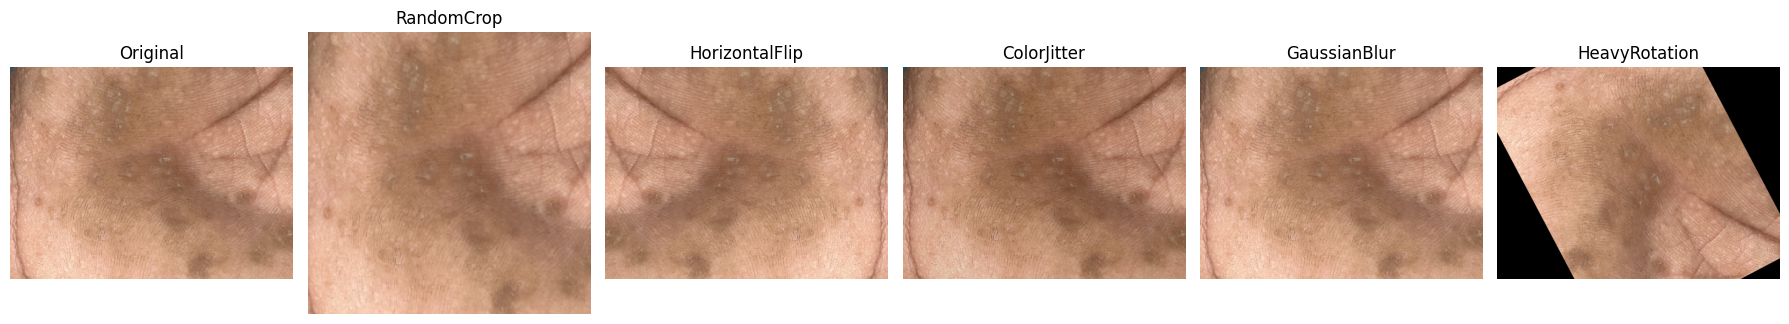

Augmentation probe complete. Visually inspect which transforms are helpful or harmful.


In [11]:
sample_path = train_df['filepath'].sample(1, random_state=42).iloc[0]
img = Image.open(sample_path)

augmentations = {
    "RandomCrop": T.RandomResizedCrop(size=244, scale=(0.8, 1.0)),
    "HorizontalFlip": T.RandomHorizontalFlip(p=1.0),
    "ColorJitter": T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    "GaussianBlur": T.GaussianBlur(kernel_size=5),
    "HeavyRotation": T.RandomRotation(degrees=90),
}

fig, axes = plt.subplots(1, len(augmentations)+1, figsize=(18,5))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

for i, (name, aug) in enumerate(augmentations.items(), 1):
    transformed = aug(img)
    axes[i].imshow(transformed)
    axes[i].set_title(name)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print("Augmentation probe complete. Visually inspect which transforms are helpful or harmful.")

# Validation Split 

# train (90%)

# validation (10%) of 90% train

# test (10%)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

# Step 1: Train (90%) + Test (10%)
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42
)

# Step 2: Split Train into Train (90% of 90%) and Validation (10% of 90%)
val_size = 0.1  # 10% of training set
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")

Train size: 1042
Validation size: 116
Test size: 129

Train class distribution:
label
infacted        600
not_infacted    442
Name: count, dtype: int64

Validation class distribution:
label
infacted        67
not_infacted    49
Name: count, dtype: int64

Test class distribution:
label
infacted        74
not_infacted    55
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Classes: ['infacted', 'not_infacted'], Num_classes: 2


100%|██████████| 49.7M/49.7M [00:00<00:00, 177MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.5803 Acc:71.02% | Val Loss:0.4003 Acc:89.66%
Epoch 2/50 - Train Loss:0.3933 Acc:86.47% | Val Loss:0.2623 Acc:90.52%
Epoch 3/50 - Train Loss:0.3046 Acc:88.39% | Val Loss:0.1897 Acc:94.83%
Epoch 4/50 - Train Loss:0.2460 Acc:89.73% | Val Loss:0.1418 Acc:96.55%
Epoch 5/50 - Train Loss:0.2039 Acc:92.13% | Val Loss:0.1130 Acc:97.41%
Epoch 6/50 - Train Loss:0.1937 Acc:91.75% | Val Loss:0.0914 Acc:99.14%
Epoch 7/50 - Train Loss:0.1631 Acc:94.53% | Val Loss:0.0723 Acc:99.14%
Epoch 8/50 - Train Loss:0.1493 Acc:95.20% | Val Loss:0.0772 Acc:97.41%
Epoch 9/50 - Train Loss:0.1307 Acc:95.39% | Val Loss:0.0541 Acc:99.14%
Epoch 10/50 - Train Loss:0.1268 Acc:95.11% | Val Loss:0.0444 Acc:100.00%
Epoch 11/50 - Train Loss:0.1324 Acc:94.63% | Val Loss:0.0396 Acc:99.14%
Epoch 12/50 - Train Loss:0.1185 Acc:96.07% | Val Loss:0.0354 Acc:100.00%
Epoch 13/50 - Train Loss:0.1113 Acc:95.78% | Val Loss:0.0316 Acc:100.00%
Epoch 14/50 - Train Loss:0.0769 Acc:97.02% | Val Loss:0.0306 Acc:99.14

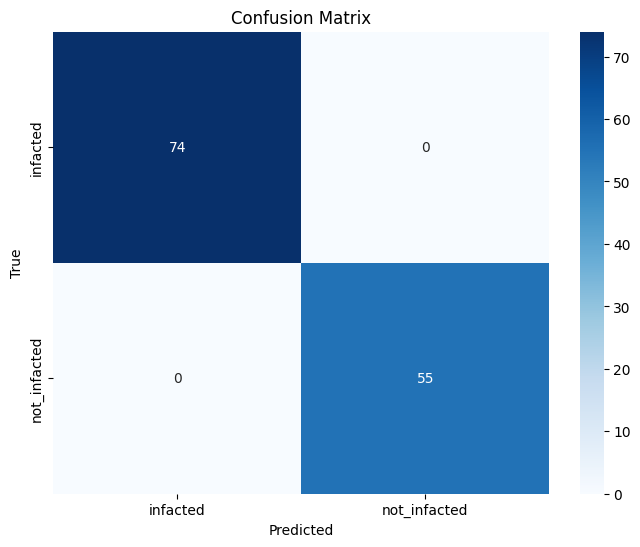

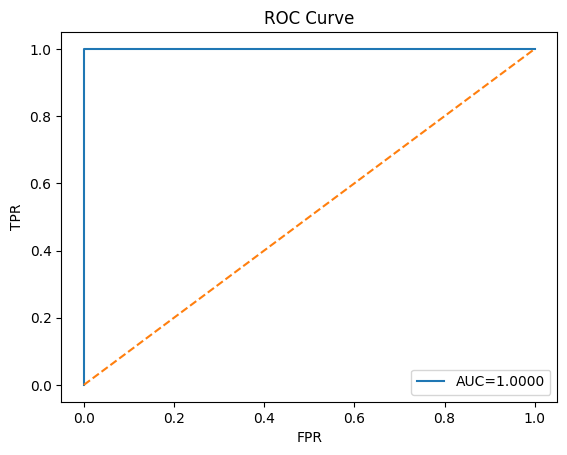

GFLOPs per inference at 224x224: 1.50


In [13]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")


# Validation Split 

# train (80%)

# validation (10%) of 80% train

# test (20%)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# df should have at least ['filepath', 'label']

# Step 1: Train (80%) + Test (20%)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Step 2: From the Train (80%), allocate 10% as Validation
val_size = 0.1  # 10% of the training portion
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")


Train size: 926
Validation size: 103
Test size: 258

Train class distribution:
label
infacted        533
not_infacted    393
Name: count, dtype: int64

Validation class distribution:
label
infacted        59
not_infacted    44
Name: count, dtype: int64

Test class distribution:
label
infacted        149
not_infacted    109
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


Classes: ['infacted', 'not_infacted'], Num_classes: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.6074 Acc:67.60% | Val Loss:0.4622 Acc:88.35%
Epoch 2/50 - Train Loss:0.4228 Acc:85.64% | Val Loss:0.2954 Acc:91.26%
Epoch 3/50 - Train Loss:0.3145 Acc:89.31% | Val Loss:0.2167 Acc:91.26%
Epoch 4/50 - Train Loss:0.2649 Acc:90.06% | Val Loss:0.2006 Acc:92.23%
Epoch 5/50 - Train Loss:0.2217 Acc:91.79% | Val Loss:0.1529 Acc:94.17%
Epoch 6/50 - Train Loss:0.1912 Acc:93.30% | Val Loss:0.1394 Acc:95.15%
Epoch 7/50 - Train Loss:0.1458 Acc:94.71% | Val Loss:0.1121 Acc:96.12%
Epoch 8/50 - Train Loss:0.1494 Acc:94.49% | Val Loss:0.1034 Acc:96.12%
Epoch 9/50 - Train Loss:0.1330 Acc:95.25% | Val Loss:0.0945 Acc:96.12%
Epoch 10/50 - Train Loss:0.1251 Acc:95.36% | Val Loss:0.0792 Acc:98.06%
Epoch 11/50 - Train Loss:0.1233 Acc:95.90% | Val Loss:0.0627 Acc:98.06%
Epoch 12/50 - Train Loss:0.1363 Acc:94.49% | Val Loss:0.0692 Acc:96.12%
Epoch 13/50 - Train Loss:0.1068 Acc:96.54% | Val Loss:0.0506 Acc:98.06%
Epoch 14/50 - Train Loss:0.1290 Acc:94.82% | Val Loss:0.0506 Acc:99.03%
E

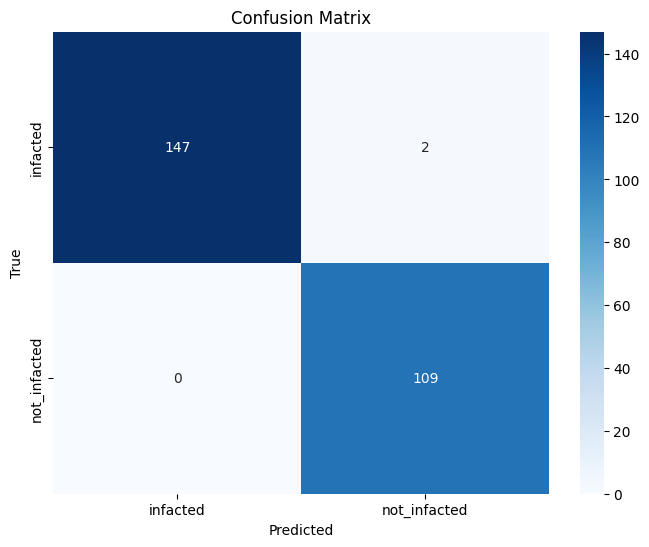

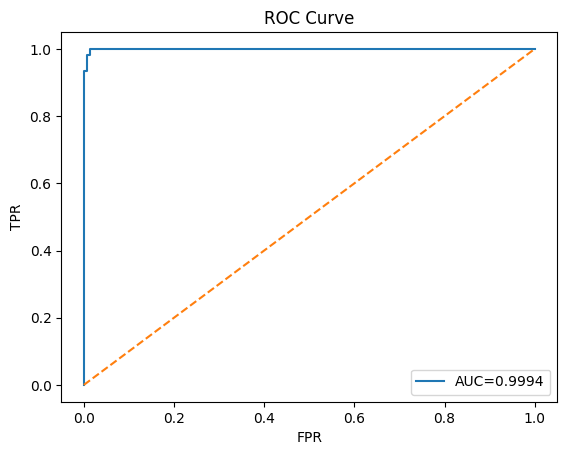

GFLOPs per inference at 224x224: 1.50


In [15]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")


# Validation Split 

# train (70%)

# validation (10%) of 70% train

# test (30%)

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label']

# Step 1: Train (70%) + Test (30%)
train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label"],
    random_state=42
)

# Step 2: From the Train (70%), take 10% for validation
val_size = 0.1  # 10% of train part
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs (Kaggle path or local path)
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")


Train size: 810
Validation size: 90
Test size: 387

Train class distribution:
label
infacted        466
not_infacted    344
Name: count, dtype: int64

Validation class distribution:
label
infacted        52
not_infacted    38
Name: count, dtype: int64

Test class distribution:
label
infacted        223
not_infacted    164
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


Classes: ['infacted', 'not_infacted'], Num_classes: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.6512 Acc:62.47% | Val Loss:0.5020 Acc:77.78%
Epoch 2/50 - Train Loss:0.4556 Acc:82.10% | Val Loss:0.3476 Acc:86.67%
Epoch 3/50 - Train Loss:0.3656 Acc:85.93% | Val Loss:0.2865 Acc:87.78%
Epoch 4/50 - Train Loss:0.3082 Acc:87.53% | Val Loss:0.2141 Acc:92.22%
Epoch 5/50 - Train Loss:0.2573 Acc:90.62% | Val Loss:0.2067 Acc:92.22%
Epoch 6/50 - Train Loss:0.2266 Acc:91.36% | Val Loss:0.1840 Acc:93.33%
Epoch 7/50 - Train Loss:0.1826 Acc:93.58% | Val Loss:0.1865 Acc:92.22%
Epoch 8/50 - Train Loss:0.1717 Acc:93.58% | Val Loss:0.1785 Acc:92.22%
Epoch 9/50 - Train Loss:0.1747 Acc:93.33% | Val Loss:0.1727 Acc:92.22%
Epoch 10/50 - Train Loss:0.1475 Acc:95.06% | Val Loss:0.1320 Acc:93.33%
Epoch 11/50 - Train Loss:0.1518 Acc:93.58% | Val Loss:0.1218 Acc:94.44%
Epoch 12/50 - Train Loss:0.1242 Acc:95.19% | Val Loss:0.1239 Acc:94.44%
Epoch 13/50 - Train Loss:0.1358 Acc:94.69% | Val Loss:0.0922 Acc:98.89%
Epoch 14/50 - Train Loss:0.0974 Acc:97.16% | Val Loss:0.1016 Acc:96.67%
E

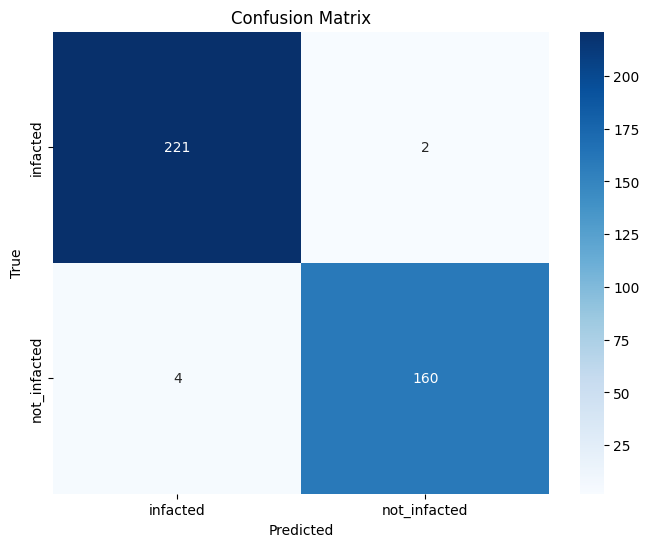

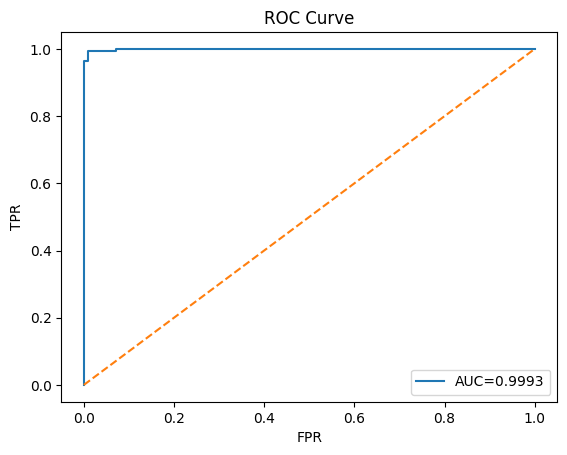

GFLOPs per inference at 224x224: 1.50


In [17]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")


# Validation Split 

# train (60%)

# validation (10%) of 60% train

# test (40%)

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label']

# Step 1: Train (60%) + Test (40%)
train_df, test_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df["label"],
    random_state=42
)

# Step 2: From the Train (60%), allocate 10% of it as Validation
val_size = 0.1  # 10% of the training portion
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs (path for Kaggle/local)
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")


Train size: 694
Validation size: 78
Test size: 515

Train class distribution:
label
infacted        399
not_infacted    295
Name: count, dtype: int64

Validation class distribution:
label
infacted        45
not_infacted    33
Name: count, dtype: int64

Test class distribution:
label
infacted        297
not_infacted    218
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


Classes: ['infacted', 'not_infacted'], Num_classes: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.6376 Acc:63.40% | Val Loss:0.5254 Acc:76.92%
Epoch 2/50 - Train Loss:0.4915 Acc:80.55% | Val Loss:0.3692 Acc:87.18%
Epoch 3/50 - Train Loss:0.3814 Acc:86.74% | Val Loss:0.2525 Acc:92.31%
Epoch 4/50 - Train Loss:0.3115 Acc:89.05% | Val Loss:0.1819 Acc:94.87%
Epoch 5/50 - Train Loss:0.2860 Acc:88.62% | Val Loss:0.1358 Acc:98.72%
Epoch 6/50 - Train Loss:0.2401 Acc:90.92% | Val Loss:0.1166 Acc:98.72%
Epoch 7/50 - Train Loss:0.2288 Acc:91.50% | Val Loss:0.1001 Acc:97.44%
Epoch 8/50 - Train Loss:0.2050 Acc:91.79% | Val Loss:0.0854 Acc:100.00%
Epoch 9/50 - Train Loss:0.1876 Acc:93.23% | Val Loss:0.0694 Acc:100.00%
Epoch 10/50 - Train Loss:0.1521 Acc:95.68% | Val Loss:0.0571 Acc:100.00%
Epoch 11/50 - Train Loss:0.1804 Acc:93.08% | Val Loss:0.0630 Acc:100.00%
Epoch 12/50 - Train Loss:0.1660 Acc:94.38% | Val Loss:0.0547 Acc:100.00%
Epoch 13/50 - Train Loss:0.1620 Acc:93.37% | Val Loss:0.0426 Acc:100.00%
Epoch 14/50 - Train Loss:0.1364 Acc:94.81% | Val Loss:0.0386 Acc:10

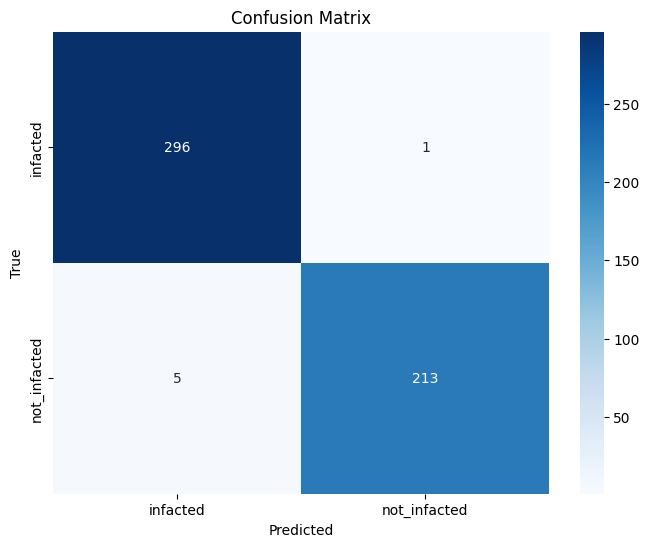

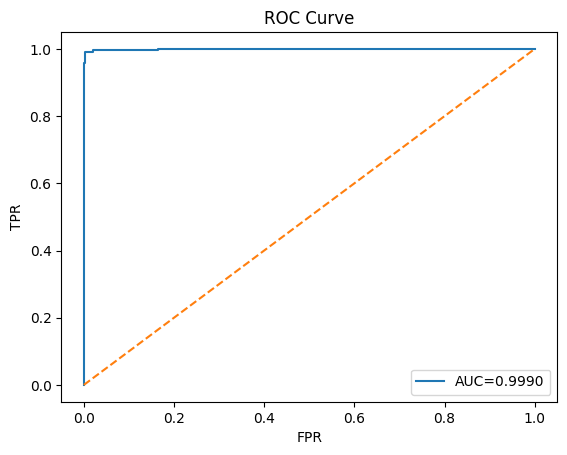

GFLOPs per inference at 224x224: 1.50


In [19]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")


# Validation Split 

# train (50%)

# validation (10%) of 50% train

# test (50%)

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label']

# Step 1: Train (50%) + Test (50%)
train_df, test_df = train_test_split(
    df,
    test_size=0.5,
    stratify=df["label"],
    random_state=42
)

# Step 2: From the Train (50%), allocate 10% of it as Validation
val_size = 0.1  # 10% of train portion
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs (Kaggle path or local)
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")


Train size: 578
Validation size: 65
Test size: 644

Train class distribution:
label
infacted        333
not_infacted    245
Name: count, dtype: int64

Validation class distribution:
label
infacted        37
not_infacted    28
Name: count, dtype: int64

Test class distribution:
label
infacted        371
not_infacted    273
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


Classes: ['infacted', 'not_infacted'], Num_classes: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.6564 Acc:60.73% | Val Loss:0.5403 Acc:81.54%
Epoch 2/50 - Train Loss:0.5110 Acc:79.24% | Val Loss:0.3812 Acc:87.69%
Epoch 3/50 - Train Loss:0.3848 Acc:87.02% | Val Loss:0.3098 Acc:90.77%
Epoch 4/50 - Train Loss:0.3235 Acc:88.41% | Val Loss:0.2515 Acc:90.77%
Epoch 5/50 - Train Loss:0.2859 Acc:90.48% | Val Loss:0.2217 Acc:90.77%
Epoch 6/50 - Train Loss:0.2930 Acc:87.89% | Val Loss:0.1828 Acc:92.31%
Epoch 7/50 - Train Loss:0.2225 Acc:92.04% | Val Loss:0.1738 Acc:93.85%
Epoch 8/50 - Train Loss:0.2051 Acc:92.39% | Val Loss:0.1599 Acc:95.38%
Epoch 9/50 - Train Loss:0.1966 Acc:93.43% | Val Loss:0.1375 Acc:96.92%
Epoch 10/50 - Train Loss:0.2083 Acc:90.83% | Val Loss:0.1347 Acc:95.38%
Epoch 11/50 - Train Loss:0.1751 Acc:94.12% | Val Loss:0.1227 Acc:95.38%
Epoch 12/50 - Train Loss:0.1611 Acc:94.29% | Val Loss:0.1057 Acc:96.92%
Epoch 13/50 - Train Loss:0.1401 Acc:94.29% | Val Loss:0.1214 Acc:96.92%
Epoch 14/50 - Train Loss:0.1700 Acc:93.43% | Val Loss:0.1026 Acc:96.92%
E

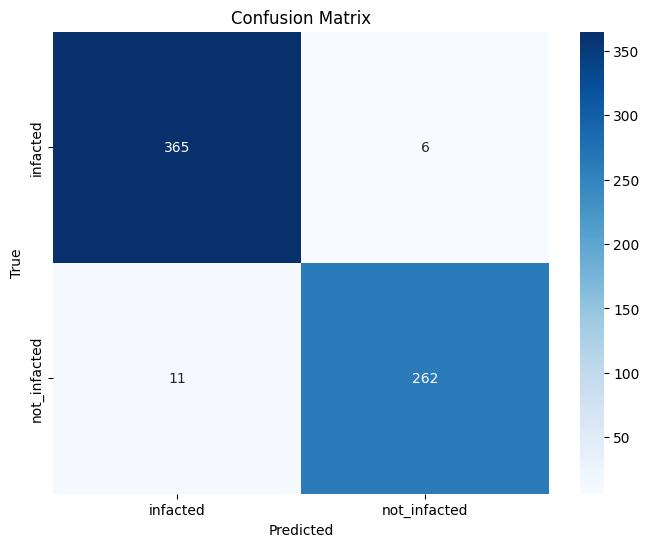

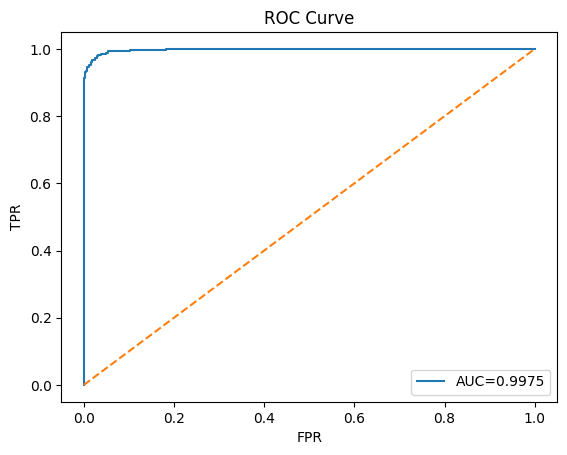

GFLOPs per inference at 224x224: 1.50


In [21]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")


# Validation Split 

# train (40%)

# validation (10%) of 40% train

# test (60%)

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label']

# Step 1: Train (40%) + Test (60%)
train_df, test_df = train_test_split(
    df,
    test_size=0.6,
    stratify=df["label"],
    random_state=42
)

# Step 2: From the Train (40%), allocate 10% of it for Validation
val_size = 0.1  # 10% of the training portion
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs (Kaggle or local path)
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")


Train size: 462
Validation size: 52
Test size: 773

Train class distribution:
label
infacted        266
not_infacted    196
Name: count, dtype: int64

Validation class distribution:
label
infacted        30
not_infacted    22
Name: count, dtype: int64

Test class distribution:
label
infacted        445
not_infacted    328
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


Classes: ['infacted', 'not_infacted'], Num_classes: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.6925 Acc:52.38% | Val Loss:0.5956 Acc:80.77%
Epoch 2/50 - Train Loss:0.5840 Acc:72.94% | Val Loss:0.4609 Acc:80.77%
Epoch 3/50 - Train Loss:0.4519 Acc:81.82% | Val Loss:0.3464 Acc:92.31%
Epoch 4/50 - Train Loss:0.3759 Acc:87.01% | Val Loss:0.2891 Acc:88.46%
Epoch 5/50 - Train Loss:0.3066 Acc:90.04% | Val Loss:0.2398 Acc:92.31%
Epoch 6/50 - Train Loss:0.2832 Acc:89.39% | Val Loss:0.2187 Acc:92.31%
Epoch 7/50 - Train Loss:0.2495 Acc:90.91% | Val Loss:0.1778 Acc:94.23%
Epoch 8/50 - Train Loss:0.2185 Acc:92.42% | Val Loss:0.1595 Acc:96.15%
Epoch 9/50 - Train Loss:0.2153 Acc:90.91% | Val Loss:0.1304 Acc:96.15%
Epoch 10/50 - Train Loss:0.2140 Acc:90.48% | Val Loss:0.1100 Acc:96.15%
Epoch 11/50 - Train Loss:0.1969 Acc:92.64% | Val Loss:0.1012 Acc:98.08%
Epoch 12/50 - Train Loss:0.1854 Acc:92.21% | Val Loss:0.0858 Acc:98.08%
Epoch 13/50 - Train Loss:0.1557 Acc:94.81% | Val Loss:0.0908 Acc:98.08%
Epoch 14/50 - Train Loss:0.1682 Acc:94.59% | Val Loss:0.0892 Acc:98.08%
E

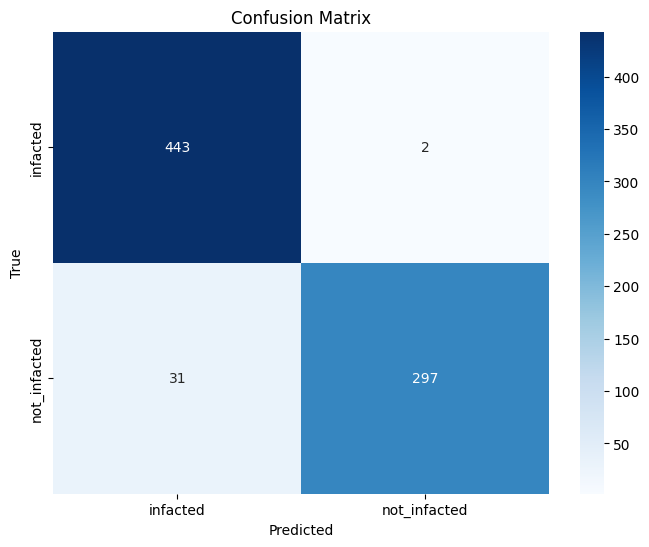

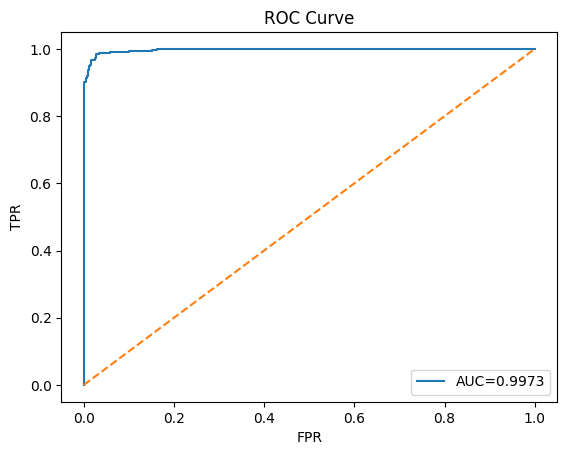

GFLOPs per inference at 224x224: 1.50


In [23]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")

# Validation Split 

# train (30%)

# validation (10%) of 30% train

# test (70%)

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# df should have at least ['filepath', 'label']

# Step 1: Train (30%) + Test (70%)
train_df, test_df = train_test_split(
    df,
    test_size=0.7,
    stratify=df["label"],
    random_state=42
)

# Step 2: From the Train (30%), allocate 10% as Validation
val_size = 0.1  # 10% of the training portion
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")


Train size: 347
Validation size: 39
Test size: 901

Train class distribution:
label
infacted        200
not_infacted    147
Name: count, dtype: int64

Validation class distribution:
label
infacted        22
not_infacted    17
Name: count, dtype: int64

Test class distribution:
label
infacted        519
not_infacted    382
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


Classes: ['infacted', 'not_infacted'], Num_classes: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.7304 Acc:48.41% | Val Loss:0.6820 Acc:58.97%
Epoch 2/50 - Train Loss:0.6207 Acc:66.57% | Val Loss:0.5530 Acc:87.18%
Epoch 3/50 - Train Loss:0.5429 Acc:78.39% | Val Loss:0.4526 Acc:82.05%
Epoch 4/50 - Train Loss:0.4624 Acc:83.57% | Val Loss:0.3731 Acc:89.74%
Epoch 5/50 - Train Loss:0.4005 Acc:85.01% | Val Loss:0.3209 Acc:89.74%
Epoch 6/50 - Train Loss:0.3733 Acc:86.74% | Val Loss:0.2656 Acc:92.31%
Epoch 7/50 - Train Loss:0.3133 Acc:89.63% | Val Loss:0.2463 Acc:89.74%
Epoch 8/50 - Train Loss:0.3124 Acc:88.47% | Val Loss:0.1970 Acc:94.87%
Epoch 9/50 - Train Loss:0.3035 Acc:88.18% | Val Loss:0.1832 Acc:94.87%
Epoch 10/50 - Train Loss:0.2499 Acc:91.07% | Val Loss:0.1537 Acc:97.44%
Epoch 11/50 - Train Loss:0.2212 Acc:91.35% | Val Loss:0.1536 Acc:94.87%
Epoch 12/50 - Train Loss:0.1930 Acc:93.95% | Val Loss:0.1226 Acc:97.44%
Epoch 13/50 - Train Loss:0.2090 Acc:93.08% | Val Loss:0.1040 Acc:97.44%
Epoch 14/50 - Train Loss:0.1805 Acc:92.51% | Val Loss:0.0873 Acc:97.44%
E

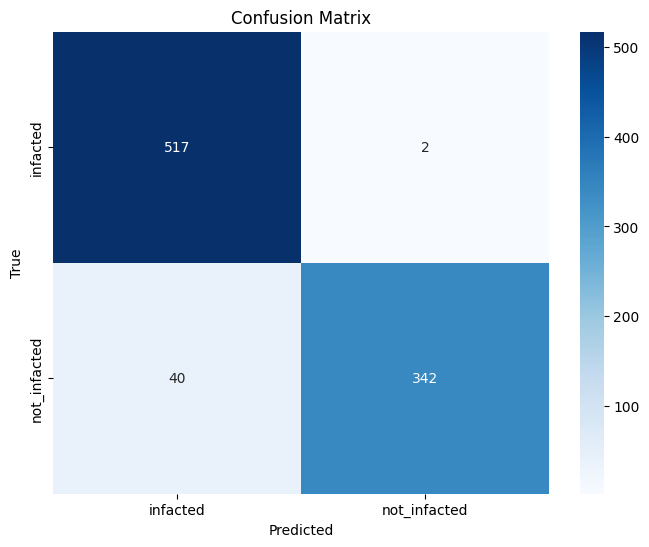

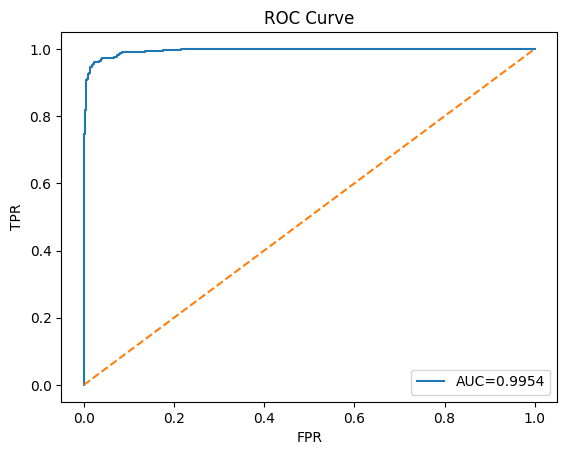

GFLOPs per inference at 224x224: 1.50


In [25]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")

# Validation Split 

# train (20%)

# validation (10%) of 20% train

# test (80%)

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

# df should have at least ['filepath', 'label']

# Step 1: Train (20%) + Test (80%)
train_df, test_df = train_test_split(
    df,
    test_size=0.8,
    stratify=df["label"],
    random_state=42
)

# Step 2: From the Train (20%), allocate 10% as Validation
val_size = 0.1  # 10% of the training portion
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs (Kaggle or local path)
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")

Train size: 231
Validation size: 26
Test size: 1030

Train class distribution:
label
infacted        133
not_infacted     98
Name: count, dtype: int64

Validation class distribution:
label
infacted        15
not_infacted    11
Name: count, dtype: int64

Test class distribution:
label
infacted        593
not_infacted    437
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


Classes: ['infacted', 'not_infacted'], Num_classes: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.7085 Acc:48.92% | Val Loss:0.6536 Acc:61.54%
Epoch 2/50 - Train Loss:0.6354 Acc:60.61% | Val Loss:0.6235 Acc:65.38%
Epoch 3/50 - Train Loss:0.5817 Acc:70.56% | Val Loss:0.5533 Acc:73.08%
Epoch 4/50 - Train Loss:0.5009 Acc:84.85% | Val Loss:0.4993 Acc:84.62%
Epoch 5/50 - Train Loss:0.4286 Acc:85.28% | Val Loss:0.4775 Acc:73.08%
Epoch 6/50 - Train Loss:0.4030 Acc:83.12% | Val Loss:0.4406 Acc:84.62%
Epoch 7/50 - Train Loss:0.3539 Acc:87.45% | Val Loss:0.4108 Acc:88.46%
Epoch 8/50 - Train Loss:0.3445 Acc:87.45% | Val Loss:0.4083 Acc:80.77%
Epoch 9/50 - Train Loss:0.2981 Acc:91.34% | Val Loss:0.3470 Acc:88.46%
Epoch 10/50 - Train Loss:0.2763 Acc:91.34% | Val Loss:0.3283 Acc:88.46%
Epoch 11/50 - Train Loss:0.2632 Acc:90.48% | Val Loss:0.3371 Acc:88.46%
Epoch 12/50 - Train Loss:0.2338 Acc:91.77% | Val Loss:0.3052 Acc:88.46%
Epoch 13/50 - Train Loss:0.2276 Acc:92.64% | Val Loss:0.2680 Acc:88.46%
Epoch 14/50 - Train Loss:0.2239 Acc:91.34% | Val Loss:0.2500 Acc:92.31%
E

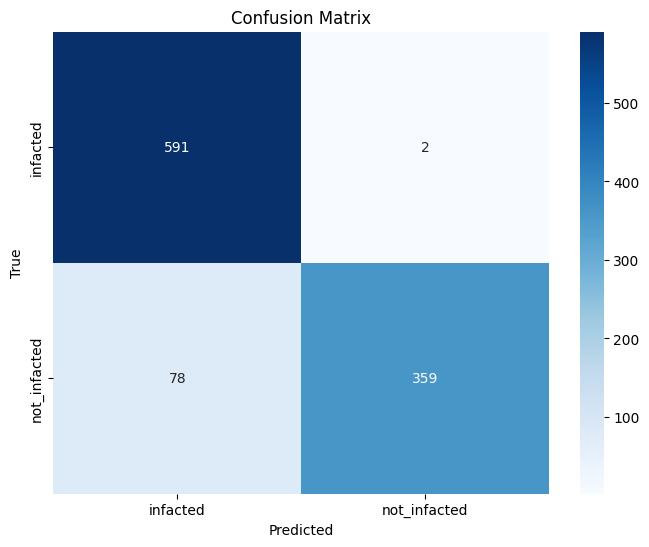

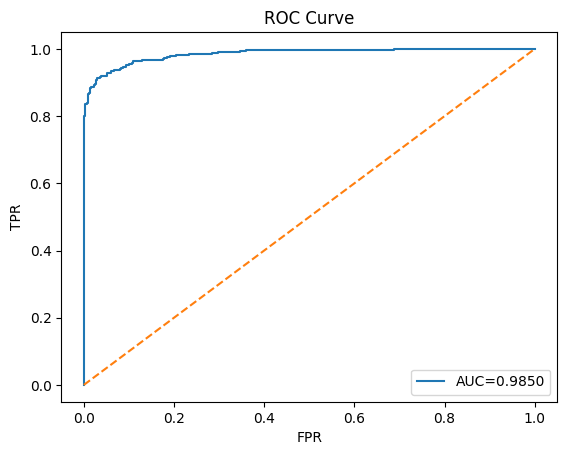

GFLOPs per inference at 224x224: 1.50


In [27]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")

# Validation Split 

# train (10%)

# validation (10%) of 10% train

# test (90%)

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split

# df should have columns: ['filepath', 'label']

# Step 1: Train (10%) + Test (90%)
train_df, test_df = train_test_split(
    df,
    test_size=0.9,
    stratify=df["label"],
    random_state=42
)

# Step 2: From the Train (10%), allocate 10% as Validation
val_size = 0.1  # 10% of train portion
train_df, val_df = train_test_split(
    train_df,
    test_size=val_size,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs (Kaggle or local path)
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")


Train size: 115
Validation size: 13
Test size: 1159

Train class distribution:
label
infacted        66
not_infacted    49
Name: count, dtype: int64

Validation class distribution:
label
infacted        8
not_infacted    5
Name: count, dtype: int64

Test class distribution:
label
infacted        667
not_infacted    492
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


Classes: ['infacted', 'not_infacted'], Num_classes: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/50 - Train Loss:0.6760 Acc:57.39% | Val Loss:0.6556 Acc:76.92%
Epoch 2/50 - Train Loss:0.6504 Acc:65.22% | Val Loss:0.6169 Acc:69.23%
Epoch 3/50 - Train Loss:0.6319 Acc:60.87% | Val Loss:0.5933 Acc:76.92%
Epoch 4/50 - Train Loss:0.5836 Acc:71.30% | Val Loss:0.5773 Acc:92.31%
Epoch 5/50 - Train Loss:0.5428 Acc:78.26% | Val Loss:0.5623 Acc:92.31%
Epoch 6/50 - Train Loss:0.5149 Acc:83.48% | Val Loss:0.5415 Acc:92.31%
Epoch 7/50 - Train Loss:0.4822 Acc:83.48% | Val Loss:0.5299 Acc:92.31%
Epoch 8/50 - Train Loss:0.4745 Acc:84.35% | Val Loss:0.5157 Acc:84.62%
Epoch 9/50 - Train Loss:0.4510 Acc:80.00% | Val Loss:0.4862 Acc:84.62%
Epoch 10/50 - Train Loss:0.3968 Acc:85.22% | Val Loss:0.4784 Acc:84.62%
Epoch 11/50 - Train Loss:0.4114 Acc:86.96% | Val Loss:0.4621 Acc:84.62%
Epoch 12/50 - Train Loss:0.4038 Acc:83.48% | Val Loss:0.4405 Acc:84.62%
Epoch 13/50 - Train Loss:0.3263 Acc:89.57% | Val Loss:0.4364 Acc:84.62%
Epoch 14/50 - Train Loss:0.3284 Acc:90.43% | Val Loss:0.4255 Acc:84.62%
E

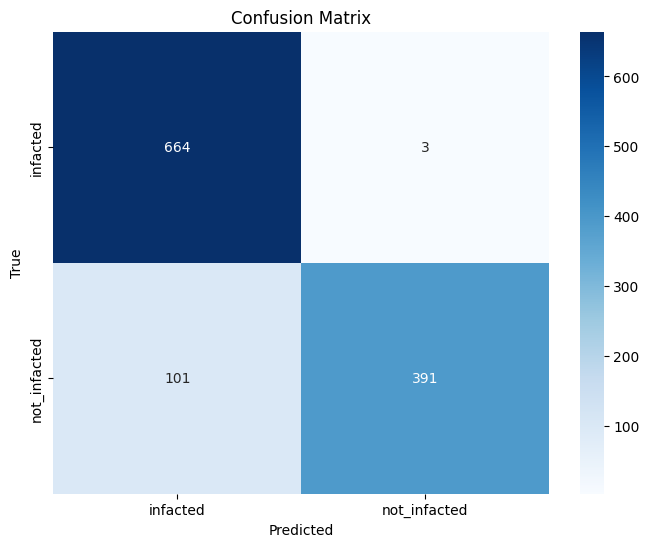

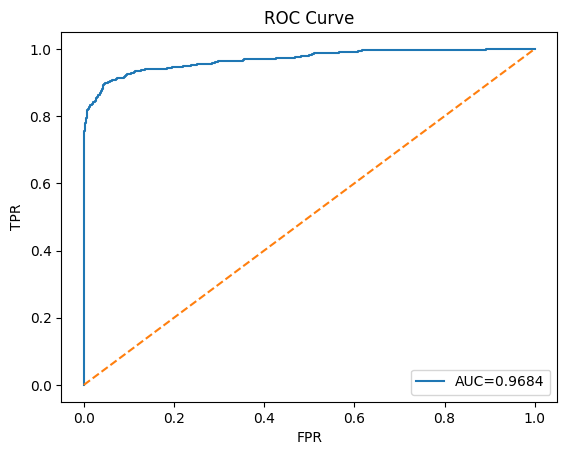

GFLOPs per inference at 224x224: 1.50


In [29]:
# googlenet_csv.py
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional GFLOPs calculation
try:
    from fvcore.nn import FlopCountAnalysis
except ImportError:
    FlopCountAnalysis = None
    print("fvcore not installed. GFLOPs calculation will be skipped.")

# ------------------------
# Config
# ------------------------
CSV_DIR = "/kaggle/working"  # path where your train_split.csv etc are
TRAIN_CSV = os.path.join(CSV_DIR, "train_split.csv")
VAL_CSV = os.path.join(CSV_DIR, "val_split.csv")
TEST_CSV = os.path.join(CSV_DIR, "test_split.csv")

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------------
# Custom Dataset
# ------------------------
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = self.class_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------
# Data Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ------------------------
# Datasets and Loaders
# ------------------------
train_dataset = CustomImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = CustomImageDataset(VAL_CSV, transform=val_transform)
test_dataset = CustomImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Num_classes: {NUM_CLASSES}")

# ------------------------
# Model
# ------------------------
model = models.googlenet(pretrained=True, aux_logits=True)
# Replace final fc
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
# Replace aux fc
if model.aux_logits:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, NUM_CLASSES)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ------------------------
# Training function
# ------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0,0,0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(inputs)
        loss_main = criterion(outputs, labels)
        loss = loss_main + 0.3*criterion(aux1, labels) + 0.3*criterion(aux2, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        running_loss += loss_main.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

# ------------------------
# Validation function
# ------------------------
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0,0,0
    all_labels, all_preds, all_probs = [],[],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs=outputs[0]
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs,1)
            _, preds = torch.max(outputs,1)
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data).item()
            total += inputs.size(0)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().numpy())
    return running_loss/total, running_corrects/total, all_labels, all_preds, np.array(all_probs)

# ------------------------
# GFLOPs
# ------------------------
def compute_gflops(model, input_size=(1,3,224,224)):
    if FlopCountAnalysis is None:
        print("fvcore missing, skipping GFLOPs")
        return None
    model.eval()
    x = torch.randn(input_size).to(DEVICE)
    flops = FlopCountAnalysis(model, x)
    return flops.total()/1e9

# ------------------------
# Training Loop
# ------------------------
best_val_acc = 0
train_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss:{train_loss:.4f} Acc:{train_acc*100:.2f}% | "
          f"Val Loss:{val_loss:.4f} Acc:{val_acc*100:.2f}%")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR,"googlenet_best.pth"))

train_end = time.time()
print(f"Total training time: {train_end-train_start:.1f}s")

# ------------------------
# Test metrics
# ------------------------
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, criterion, DEVICE)
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# Per-class accuracy
y_true_np = np.array(test_labels)
y_pred_np = np.array(test_preds)
for i, cls in enumerate(test_dataset.classes):
    idx = y_true_np==i
    acc = np.mean(y_pred_np[idx]==i) if np.sum(idx)>0 else 0
    print(f"Class {cls} Accuracy: {acc*100:.2f}%")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if NUM_CLASSES==2:
    auc = roc_auc_score(test_labels, test_probs[:,1])
    fpr,tpr,_ = roc_curve(test_labels, test_probs[:,1])
    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))
    auc = roc_auc_score(y_true_bin, test_probs, average='macro', multi_class='ovr')
    print(f"Multi-class ROC-AUC: {auc:.4f}")
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], test_probs[:,i])
        plt.plot(fpr,tpr,label=f"{test_dataset.classes[i]} (AUC={roc_auc_score(y_true_bin[:,i], test_probs[:,i]):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# GFLOPs
gflops = compute_gflops(model)
if gflops:
    print(f"GFLOPs per inference at {IMG_SIZE}x{IMG_SIZE}: {gflops:.2f}")